In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

plt.style.use('dark_background')

# Evaluating a Learning Algo

## Linear Regression (degree 10) without crossvalidation

In [ ]:
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

In [ ]:
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

X.shape (18,) y.shape (18,)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=1)
print(X_train.shape," ",y_train.shape)
print(X_test.shape," ",y_test.shape)

(12,)   (12,)
(6,)   (6,)


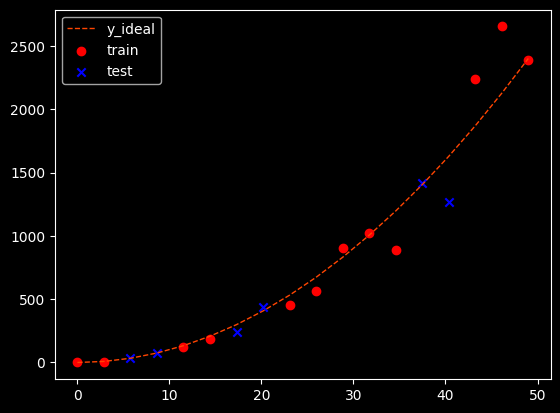

In [ ]:
plt.plot(x_ideal,y_ideal,"--",color='orangered',label='y_ideal',lw=1)
plt.scatter(X_train,y_train,color='r',marker='o',label='train')
plt.scatter(X_test,y_test,color='b',marker='x',label='test')
plt.legend()
plt.show()

In [ ]:
def eval_mse(y,y_hat):
    m=len(y)
    err=0.0
    for i in range(m):
        err+=(y[i]-y_hat[i])**2
    err/=2*m
    return err

In [ ]:
degree=10
model=LinearRegression()
poly=PolynomialFeatures(degree=degree,include_bias=False)
scalar=StandardScaler()

X_train_mapped=poly.fit_transform(X_train.reshape(-1,1))
X_train_mapped_scaled=scalar.fit_transform(X_train_mapped)
model.fit(X_train_mapped_scaled,y_train)

LinearRegression()

In [ ]:
#predict on training data
yhat_train=model.predict(X_train_mapped_scaled)
err_train=mean_squared_error(y_train,yhat_train)/2
print(f"training error : {err_train:0.2f}")

training error : 58.01


In [ ]:
#predict on test data
X_test_mapped=poly.fit_transform(X_test.reshape(-1,1))
X_test_mapped_scaled=scalar.fit_transform(X_test_mapped)
yhat_test=model.predict(X_test_mapped_scaled)
err_test=mean_squared_error(y_test,yhat_test)/2
print(f"testing error : {err_test:0.2f}")

testing error : 204398.51


In [ ]:
x=np.linspace(0,int(X.max()),100)
x_mapped=poly.fit_transform(x.reshape(-1,1))
x_mapped_scaled=scalar.fit_transform(x_mapped)
y_pred=model.predict(x_mapped_scaled).reshape(-1,1)

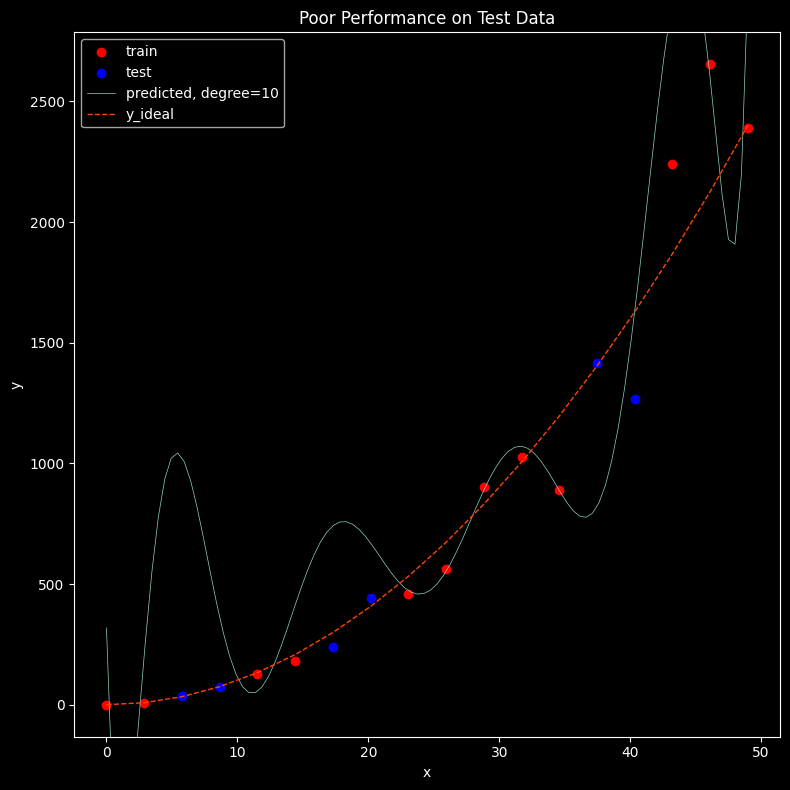

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax.set_title("Poor Performance on Test Data",fontsize = 12)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",label="train")
ax.scatter(X_test, y_test,color = "blue", label="test")
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(x, y_pred,  lw=0.5, label=f"predicted, degree={degree}")
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Cross Validation, Bias, Variance (Deciding Degree of the polynomial)

In [ ]:
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

In [ ]:
X,y,x_ideal,y_ideal=gen_data(40,5,0.7)
print(X.shape," ",y.shape)

(40,)   (40,)


In [ ]:
X_train,X_t,y_train,y_t=train_test_split(X,y,train_size=0.6,random_state=1)
X_cv,X_test,y_cv,y_test=train_test_split(X_t,y_t,test_size=0.5,random_state=1)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

(24,) (24,)
(8,) (8,)
(8,) (8,)


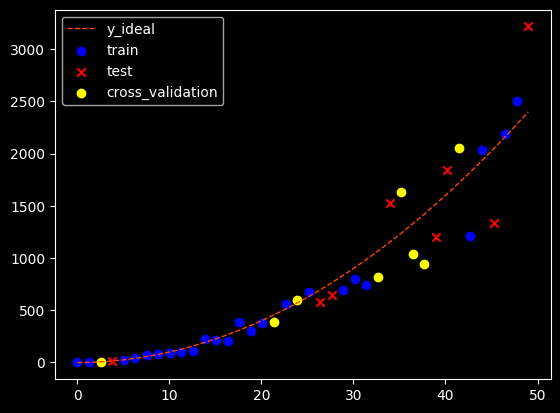

In [ ]:
plt.plot(x_ideal,y_ideal,"--",color='orangered',label='y_ideal',lw=1)
plt.scatter(X_train,y_train,marker='o',color='b',label='train')
plt.scatter(X_test,y_test,marker='x',color='r',label='test')
plt.scatter(X_cv,y_cv,color='yellow',label='cross_validation')
plt.legend()
plt.show()

**Here we will train our model repeatedly changing the degree and then finally decide the optimal degree of the polonomial bases on the least cross_validation error**

In [ ]:
n=10
err_train=np.zeros(n)
err_cv=np.zeros(n)
x=np.linspace(0,int(X.max()),100)
y_pred=np.zeros((100,n))


for degree in range(n):
    model=LinearRegression()
    poly=PolynomialFeatures(degree)
    scalar=StandardScaler()
    X_train_mapped=poly.fit_transform(X_train.reshape(-1,1))
    X_train_mapped_scaled=scalar.fit_transform(X_train_mapped)
    model.fit(X_train_mapped_scaled,y_train)
    yhat_train=model.predict(X_train_mapped_scaled)
    err_train[degree]=mean_squared_error(y_train,yhat_train)/2
    X_cv_mapped=poly.fit_transform(X_cv.reshape(-1,1))
    X_cv_mapped_scaled=scalar.fit_transform(X_cv_mapped)
    yhat_cv=model.predict(X_cv_mapped_scaled)
    err_cv[degree]=mean_squared_error(y_cv,yhat_cv)/2
    x_mapped=poly.fit_transform(x.reshape(-1,1))
    x_mapped_scaled=scalar.fit_transform(x_mapped)
    y_pred[:,degree]=model.predict(x_mapped_scaled)
optimal_degree=np.argmin(err_cv)+1
print(optimal_degree)

6


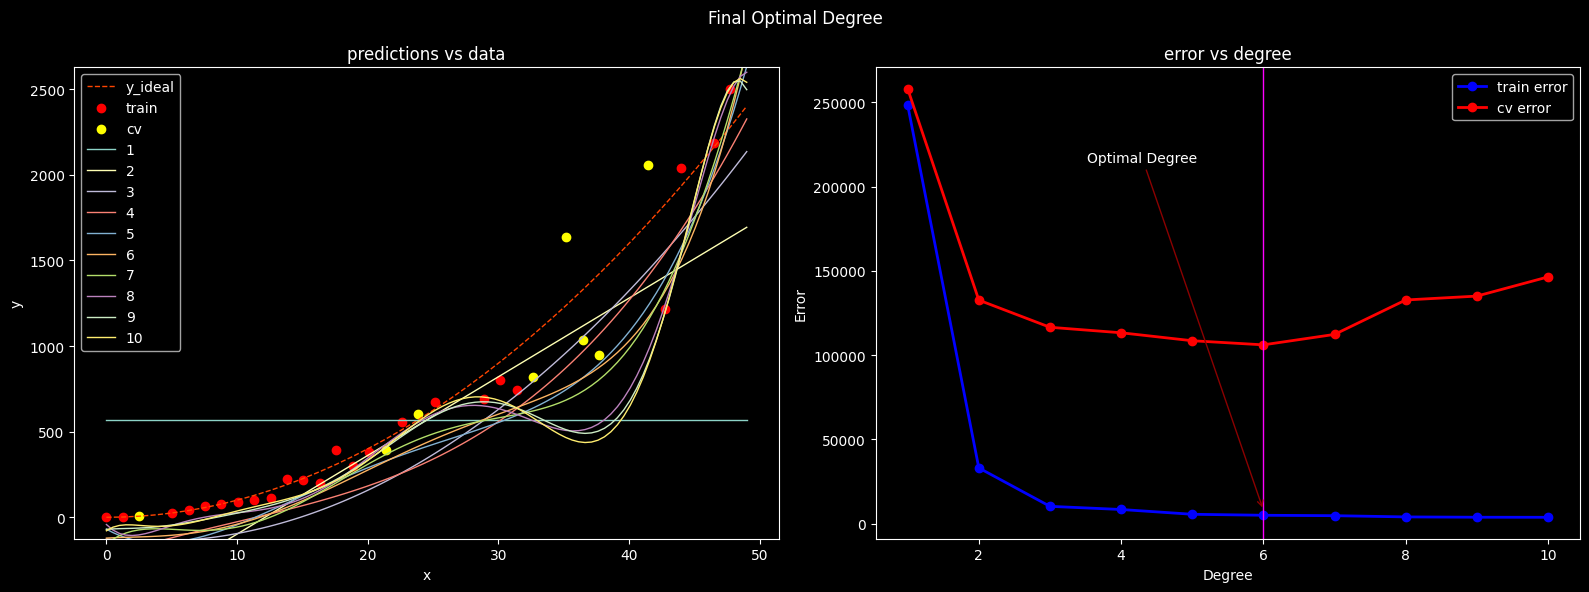

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax[0].set_title("predictions vs data",fontsize=12)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")


ax[0].plot(x_ideal,y_ideal,"--",color='orangered',label="y_ideal",lw=1)
ax[0].scatter(X_train,y_train,color='red',label='train')
ax[0].scatter(X_cv,y_cv,color='yellow',label='cv')
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
for i in range(0,n):
    ax[0].plot(x,y_pred[:,i],lw=1,label=f"{i+1}")
ax[0].legend(loc='upper left')

ax[1].set_title("error vs degree",fontsize=12)
pts=list(range(1,n+1))
ax[1].plot(pts,err_train,marker='o',label='train error',lw=2,color='blue')
ax[1].plot(pts,err_cv,marker='o',label='cv error',lw=2,color='red')
ax[1].axvline(optimal_degree,lw=1,color='magenta')
ax[1].annotate("Optimal Degree",xy=(optimal_degree,8000),xytext=(0.3,0.8),textcoords='axes fraction',fontsize=10, arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="darkred", lw=1))
ax[1].set_ylim(*ax[1].get_ylim())
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Error")
ax[1].legend()
fig.suptitle("Final Optimal Degree",fontsize=12)
plt.tight_layout()
plt.show()

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used.

* On the left plot, the solid lines represent the predictions from these models. A
polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point.
* on the right:
    * the error on the trained data (blue) decreases as the model complexity increases as expected
    * the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to generalize).
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

## Tuning Regularization

 Similar to degree, one can use the same methodology to tune the regularization parameter lambda

In [ ]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
n=len(lambda_range)
degree=10
err_train=np.zeros(n)
err_cv=np.zeros(n)
x=np.linspace(0,int(X.max()),100)
y_pred=np.zeros((100,n))

for i in range(n):
    lam_=lambda_range[i]
    model=Ridge(alpha=lam_)
    poly=PolynomialFeatures(degree,include_bias=False)
    scalar=StandardScaler()
    X_train_mapped=poly.fit_transform(X_train.reshape(-1,1))
    X_train_mapped_scaled=scalar.fit_transform(X_train_mapped)
    model.fit(X_train_mapped_scaled,y_train)
    yhat_train=model.predict(X_train_mapped_scaled)
    err_train[i]=mean_squared_error(y_train,yhat_train)/2
    X_cv_mapped=poly.fit_transform(X_cv.reshape(-1,1))
    X_cv_mapped_scaled=scalar.fit_transform(X_cv_mapped)
    yhat_cv=model.predict(X_cv_mapped_scaled)
    err_cv[i]=mean_squared_error(y_cv,yhat_cv)/2
    x_mapped=poly.fit_transform(x.reshape(-1,1))
    x_mapped_scaled=scalar.fit_transform(x_mapped)
    y_pred[:,i]=model.predict(x_mapped_scaled)
optimal_reg_idx=np.argmin(err_cv)
print(optimal_reg_idx)

5


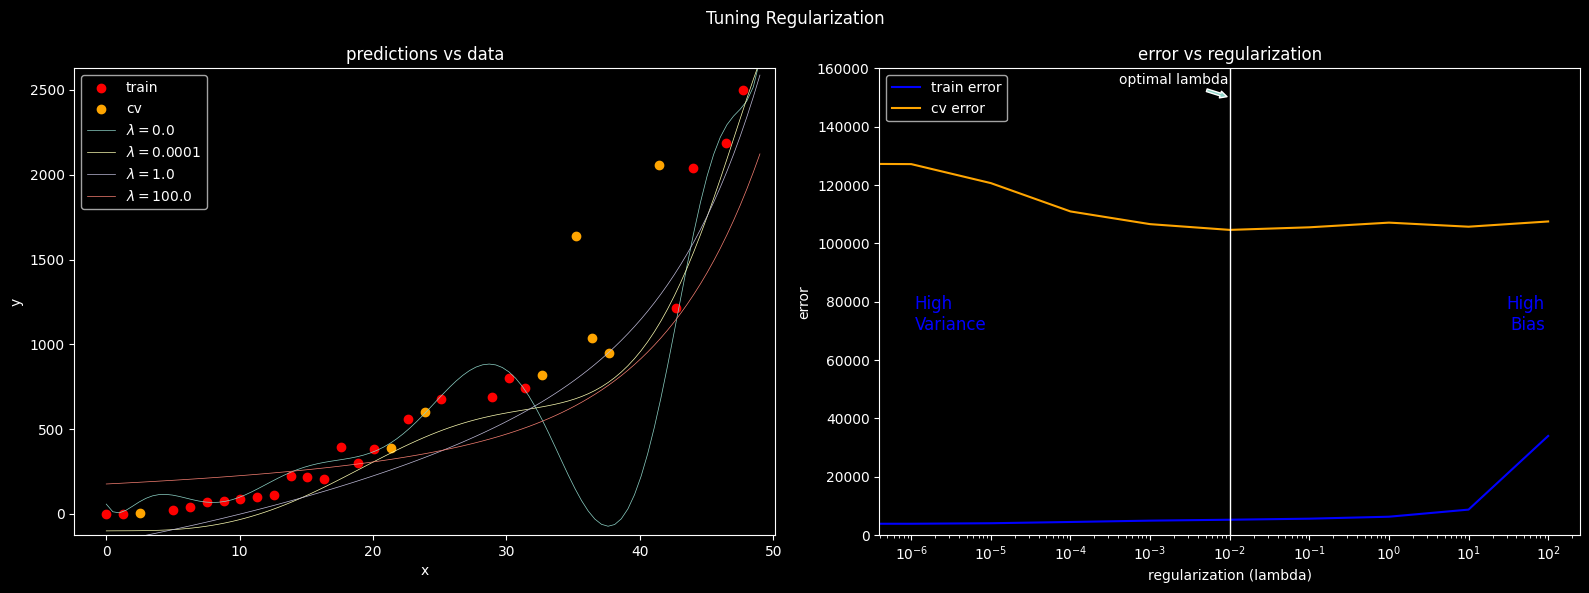

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax[0].set_title("predictions vs data",fontsize = 12)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[0].scatter(X_train, y_train, color = "red",           label="train")
ax[0].scatter(X_cv, y_cv,       color ="orange", label="cv")
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
for i in (0,3,7,9):
    ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
ax[0].legend()

ax[1].set_title("error vs regularization",fontsize = 12)
ax[1].plot(lambda_range, err_train[:], label="train error", color = "blue")
ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = "orange")
ax[1].set_xscale('log')
ax[1].set_ylim(bottom=0, top=160000)
opt_x = lambda_range[optimal_reg_idx]
ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "white", lw=1)
ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                arrowprops={'arrowstyle':'simple'})
ax[1].set_xlabel("regularization (lambda)")
ax[1].set_ylabel("error")
fig.suptitle("Tuning Regularization",fontsize = 12)
ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

## Adding More Data

In [ ]:
class lin_model:
    def __init__(self, degree, regularization = False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()

    def fit(self, X_train,y_train):
        ''' just fits the data. mapping and scaling are not repeated '''
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train )

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)

    def mse(self, y, yhat):
        err = mean_squared_error(y,yhat)/2   #sklean doesn't have div by 2
        return (err)


In [ ]:
def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)
    err_cv = np.zeros(num_steps)
    y_pred = np.zeros((100,num_steps))

    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):

    fig, ax = plt.subplots(1,2,figsize=(16,6))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color ="orange", s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = "blue")

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = "blue")
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = "orange")
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))

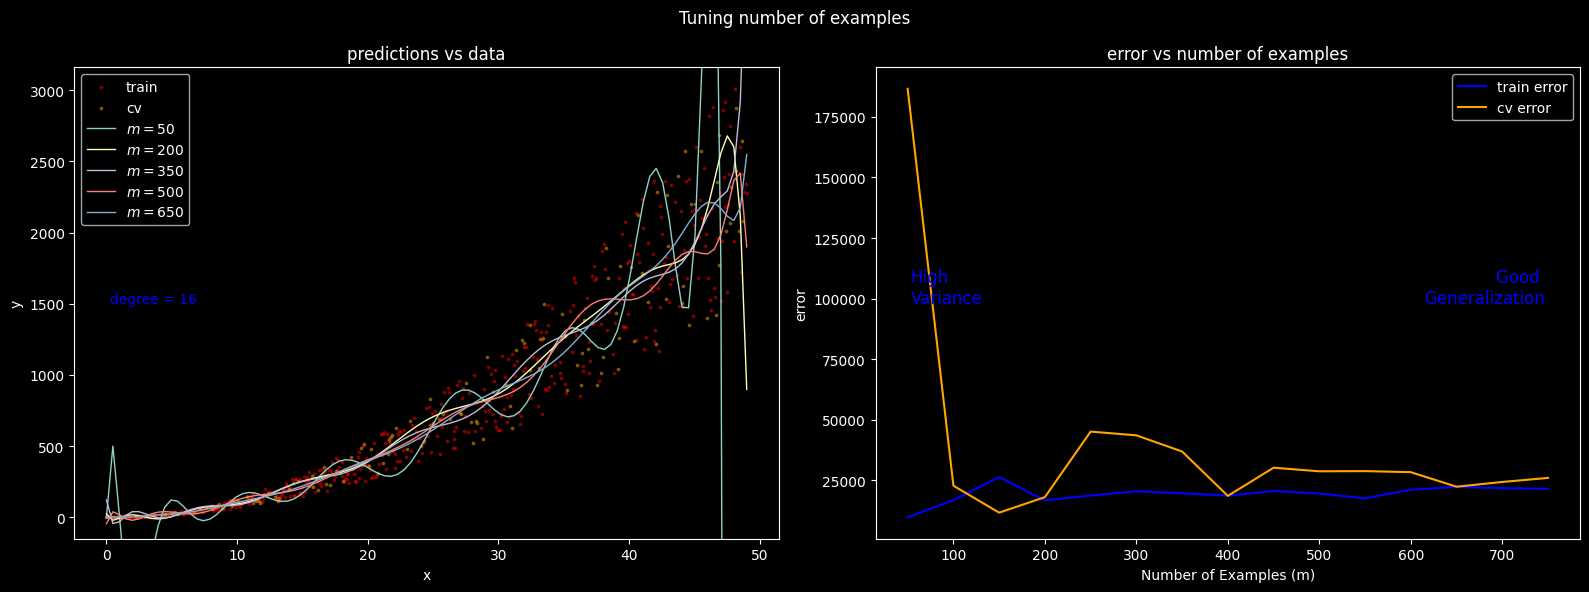

In [ ]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of
 is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization.

Note that adding more examples when the model has high bias (underfitting) does not improve performance.

# Evaluating a Learning Algorithm (Neural Network)

### Complex and Simple Model

In [ ]:
from sklearn.datasets import make_blobs
def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)

In [ ]:
X,y,centers,classes,std=gen_blobs()
print(X.shape)

(800, 2)


In [ ]:
X_train,X_,y_train,y_=train_test_split(X,y,train_size=0.5,random_state=1)
X_test,X_cv,y_test,y_cv=train_test_split(X_,y_,test_size=0.2,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(400, 2)
(320, 2)
(80, 2)


In [ ]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

import matplotlib as mpl
dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')

In [ ]:
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw)
    ax.axis('tight')

def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

In [ ]:
def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(18,6))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()

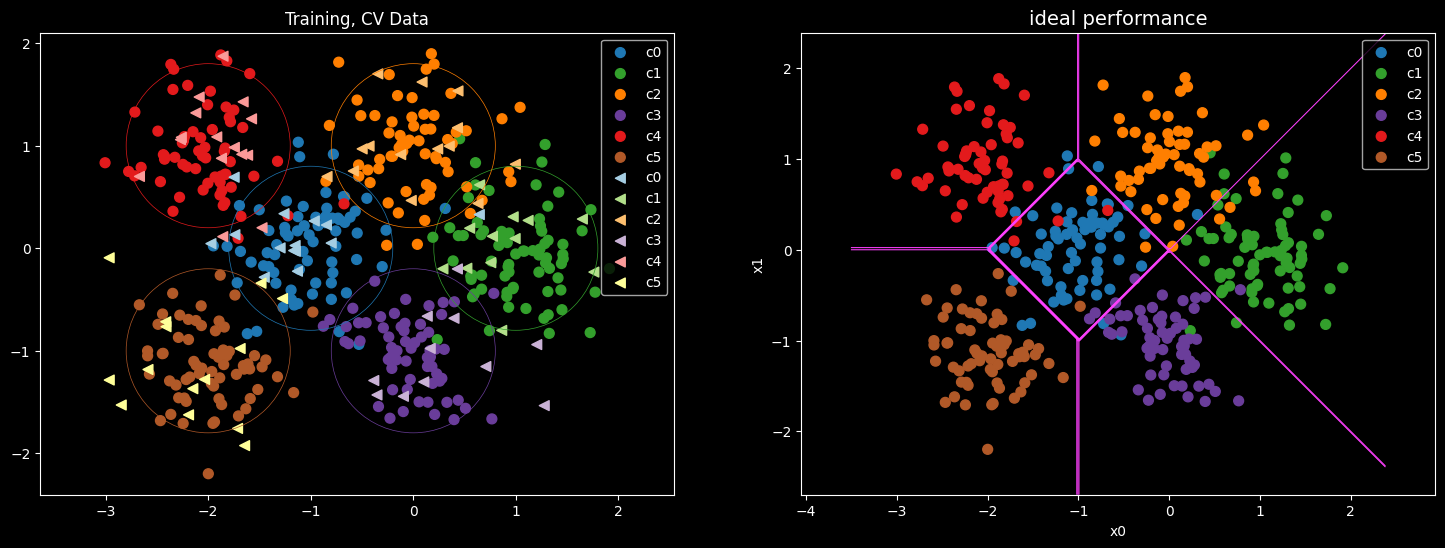

In [ ]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model=Sequential([
    tf.keras.layers.Dense(120,activation='relu'),
    tf.keras.layers.Dense(40,activation='relu'),
    tf.keras.layers.Dense(6,activation='linear')
],name='complex')
model.summary()

Model: "complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),)

In [ ]:
model.fit(X_train,y_train,epochs=1000,verbose=0)

In [ ]:
model.summary()

Model: "complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (63.83 KB)

 Trainable params: 5,446 (21.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (42.56 KB)

In [ ]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
    ], name = "Simple"
)
model_s.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
model_s.fit(
    X_train,y_train,
    epochs=1000,
    verbose=0
)

In [ ]:
model.summary()

Model: "complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (63.83 KB)

 Trainable params: 5,446 (21.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (42.56 KB)

## Regularization

Reconstruct your complex model, but this time include regularization. Below, compose a three-layer model:

* Dense layer with 120 units, relu activation, kernel_regularizer=tf.keras.
regularizers.l2(0.1)
* Dense layer with 40 units, relu activation, kernel_regularizer=tf.keras.regularizers.l2(0.1)
* Dense layer with 6 units and a linear activation. Compile using
* loss with SparseCategoricalCrossentropy, remember to use from_logits=True
* Adam optimizer with learning rate of 0.01.

In [ ]:

tf.random.set_seed(1234)
model_r = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation="linear")
    ], name= None
)
model_r.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),)

In [ ]:
model_r.fit(X_train,y_train,epochs=1000,verbose=0)

In [ ]:
model_r.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (63.83 KB)

 Trainable params: 5,446 (21.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (42.56 KB)

**Iterate to find the best regularization lambda**

In [ ]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=10, #1000
        verbose=0
    )
    print(f"Finished lambda = {lambda_}")

Finished lambda = 0.0
Finished lambda = 0.001
Finished lambda = 0.01
Finished lambda = 0.05
Finished lambda = 0.1
Finished lambda = 0.2
Finished lambda = 0.3


**As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.**

**comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)**

# Pipeline

In [ ]:
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

In [ ]:
X,y,x_ideal,y_ideal=gen_data(40,5,0.7)
print(X.shape," ",y.shape)

(40,)   (40,)


In [ ]:
X_train,X_t,y_train,y_t=train_test_split(X,y,train_size=0.6,random_state=1)
X_cv,X_test,y_cv,y_test=train_test_split(X_t,y_t,test_size=0.5,random_state=1)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

(24,) (24,)
(8,) (8,)
(8,) (8,)


In [ ]:
from sklearn.pipeline import Pipeline


degree=10

model=Pipeline(steps=[
    ('polonomial',PolynomialFeatures(degree)),
    ('scaling',StandardScaler()),
    ('regression',LinearRegression())
])

In [ ]:
model.fit(X_train.reshape(-1,1),y_train)
yhat_train=model.predict(X_train.reshape(-1,1))

In [ ]:
yhat_cv=model.predict(X_cv.reshape(-1,1))
yhat_test=model.predict(X_test.reshape(-1,1))

# Pickle to save a trained model

In [ ]:
import pickle
pickle.dump(model, open('pipe.pkl', 'wb'))

In [ ]:
# Load the saved pipeline
import pickle
pipe = pickle.load(open('pipe.pkl', 'rb'))
#y_pred = pipe.predict(X_test)